## Basic Trait Recognition CNN

The aim of this project is to construct a neural network trained on the CelebA Dataset which is able to detect a range of facial features from a given input image. This is a multi-label image classification problem, meaning each image can have multiple labels at once (as opposed to multi-class image classification, where there are multiple output classes but the image can only belong to one)

I have tried to make this notebook as simple to understand as possible with many comments and reasonings behind my decisions :)


## 1. Loading the Data

In this first section, we are going to be loading in data from a locally installed CelebA database, which you can find here:    https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

First, we are going to import some useful databases:

In [297]:
# First, input some useful libraries
import os

# General Image/Array Libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Next, we have our usual torch and torchvision imports.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

# Defining Hyper Parameters:

Next, we are going to define some hyper-parameters which we will use throughout the project. It is useful to define them all here in one place (I've used classes to do this) so that if we want to change them, we only have to change them once.

In [298]:
# Classes for Training and Image Processing
class DatasetConfig:
    Image_Size:     tuple = (80, 80)    # Size that images will be scaled
    Channels:       int = 3             # 3 input channels for a GPU
    Num_Classes:    int = 15            # How many characteristics/traits are in the dataset
    TestTrainSplit: float = 0.1         # What percentage to set aside for testing
    Dataset_Path:   str = "celeb_dataset"        # Pathway to the dataset
    
#Classes for Training and Image Processing
class TrainingConfig:
    Batch_Size:     int = 16            
    Num_Epochs:     int = 10
    Learning_Rate:  float = 0.001
    
#Select Device (ideally this is a GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Exploring our dataset

Now that we have defined everything, we want to load in our dataset and explore it to see what we are dealing with.

Note that a lot of this is inspired from the following youtube video:   https://www.youtube.com/watch?v=hJ8607uxF5k

In [299]:
# Reading in our labelled csv file (note: Modified to remove some categories) which contains labels for all the images
labels_path = '.\celeb_dataset\list_attr_celeba.csv'
df = pd.read_csv(labels_path)
#df.head(20)                    #Use the following line to look at the first few rows of the data

In [300]:
#Extract the names of the different classes
classes = df.columns.tolist()

#Extract the labels from the dataset
labels = []
for index, rows in df.iterrows():
    labels.append(list(rows.iloc[(DatasetConfig.Num_Classes * -1):]))
#print(labels[0:5])      #Use the following line to look at the first few rows of the data, make sure they match above

#Convert to a np array and view shape to make sure (should be num_images, num_classes)
labels = np.array(labels)
#print(labels.shape)

In [301]:
# Reading some images from the dataset
image_names = df['image_id'].tolist()

#Load the images into the notebook so we can have a look at them
images = []     #Note, this takes up a lot of memory, only gonna check the first 1000
image_root_path = '.\celeb_dataset\img_align_celeba\Celebs'
for image_name in tqdm(image_names[0:1000]):
    image = np.array(Image.open(os.path.join(image_root_path, image_name)))     #Combines image pathway with name of the image
    images.append(image)

#Convert Back to a np array (easier to work with and display)
images = np.array(images)

  0%|          | 0/1000 [00:00<?, ?it/s]

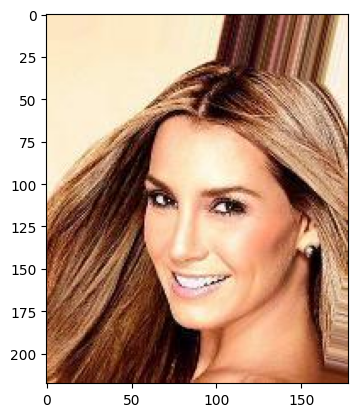

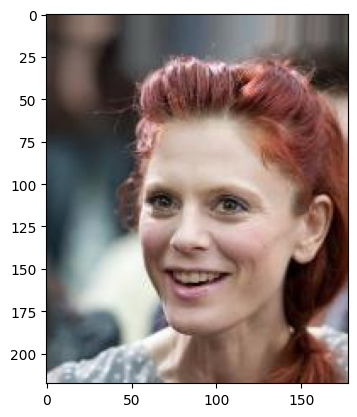

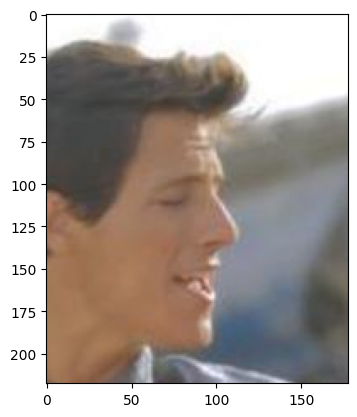

In [302]:
#Visualise some of the images
for img in images[0:3]:
    plt.imshow(img)
    plt.show()

Now that we have the images and labels loaded from the dataset, we want to have a look at the distribution and frequency of labels in our data ~ this may determine whether the dataset is suitable for training.

<BarContainer object of 15 artists>

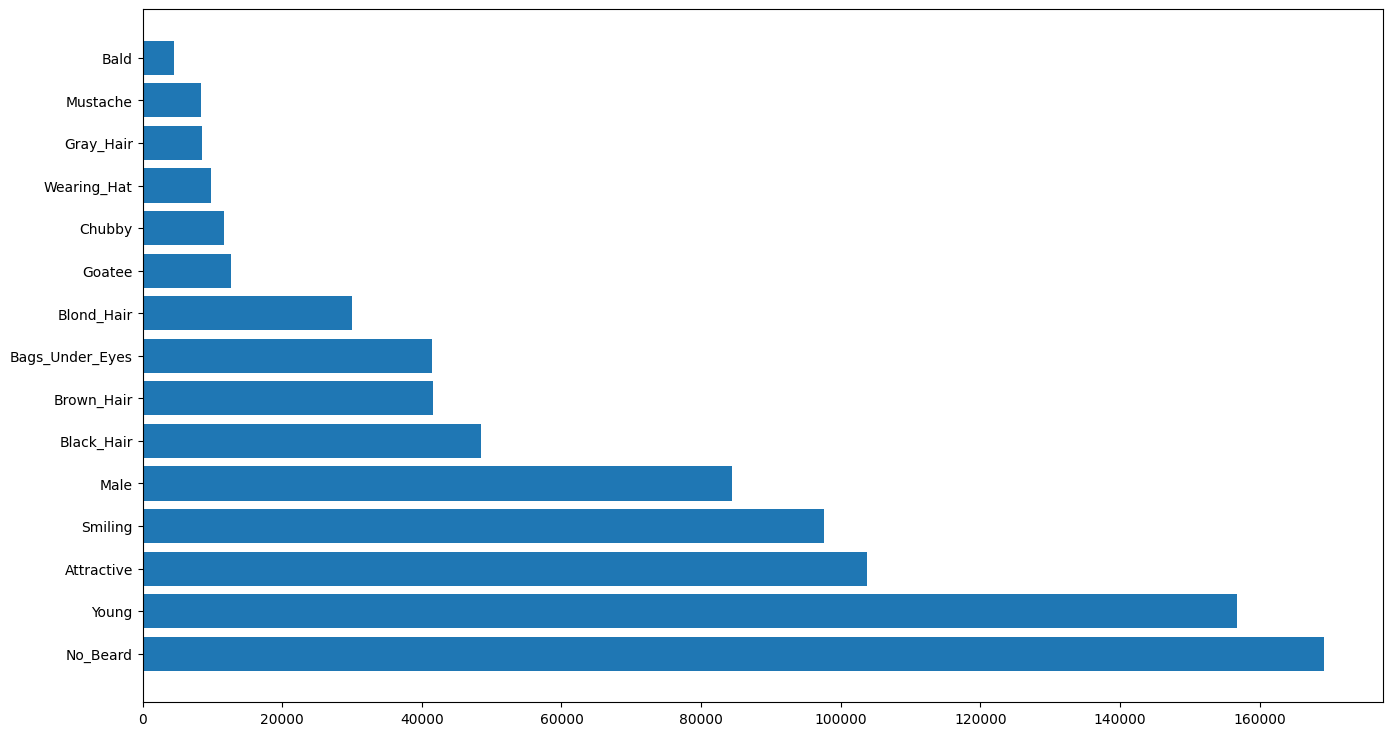

In [303]:
#Counting the number of labels per class and forming into a histogram chart
label_count = np.sum((labels+1)/2, axis=0)      #Note that because of the negative (data labelled either -1 or +1), need to +1 then divide by 2 to get count

#Plotting histogram
fig, ax = plt.subplots(figsize =(16, 9))
x, y = list(zip(*sorted(zip(label_count, classes[1:]), reverse=True)))
plt.barh(y, x)

It can be seen that there is a disparity in the data ~ some classes are underrepresented. This may mean that for over-represented data, the model will always predict positive as it would give a high accuracy and vice versa for under-represented data. Although we will use this data for now, later on we will see the implications of this data imbalance.

Note that some negative classifications imply others; if not classified as male, can assume female.

# Creating a custom dataset

Now that we have explored our data, we want to load it into a form where we can feed it into a neural network. This is done by creating a custom dataset and some dataloaders which separate the data into batches.

Note that this was inspired by the following video:     https://www.youtube.com/watch?v=ry3NH0-0Cqc

First we are going to apply some transforms to our dataset to essentially artificially increase its size without adding any new images. Because the dataset we are using contains quite a lot of images already, this step isn't too critical. When working with smaller datasets however, to avoid ove-rfitting, data augmentation is often used extensively.

In [304]:
#Defining a set of tranforms for our data
transform = transforms.Compose([transforms.Resize((DatasetConfig.Image_Size)), 
                                #transforms.RandomRotation(15),
                                #transforms.RandomCrop((DatasetConfig.Image_Size, DatasetConfig.Image_Size)),  #Can often be useful for smaller datasets     
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                        #This normalizes our data (scale from 0-1) around the given means and STD

In [305]:
#Creating a custom dataset  
class CelebDataset_MultiLabel(Dataset):
    
    def __init__(self):                 # When the dataset is made, want to load in all the images
        self.images = []
        self.labels = []
        labels_path = '.\celeb_dataset\list_attr_celeba.csv'
        image_root_path = '.\celeb_dataset\img_align_celeba\Celebs'         # Essentially the same as what we did when exploring the data to load it all in
        df = pd.read_csv(labels_path)

        #Extract the labels from the dataset
        for index, rows in df.iterrows():
            self.labels.append(list(rows.iloc[(DatasetConfig.Num_Classes * -1):]))          #This gets all the classes except the image names
        self.labels = np.array(self.labels)
        self.labels = (self.labels+1)/2                                                     #Again, need to do this to convert from range [-1, 1] to [0, 1]
        
        # Reading some images from the dataset
        image_names = df['image_id'].tolist()
        for image_name in tqdm(image_names):
            image = Image.open(os.path.join(image_root_path, image_name))
            image = transform(image)
            self.images.append(image)
            
    def __len__(self):
        return len(self.images)      # Returns the number of images in the dataset
            
    def __getitem__(self, idx):
        return self.images[idx],self.labels[idx]            #Retrieves an image from the dataset

In [307]:
#Create instance of dataset (this might take a while, as it loads in all the images)
CelebDataset = CelebDataset_MultiLabel()

  0%|          | 0/202599 [00:00<?, ?it/s]

In [308]:
#Seperate data into test and train sets (note: for a more statistical model, would want to use 10 fold cross validation and train the model 10 times with the validation set changing each time)
train, test = torch.utils.data.random_split(CelebDataset, [0.9, 0.1])

#Creating dataloader (these seperate our data into batches)
trainloader = torch.utils.data.DataLoader(train, TrainingConfig.Batch_Size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(test, TrainingConfig.Batch_Size, shuffle=True, drop_last=True)

Now that we have our custom dataset created, we want to visualize some images and labels to make sure everything was loaded in correctly.

[0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]


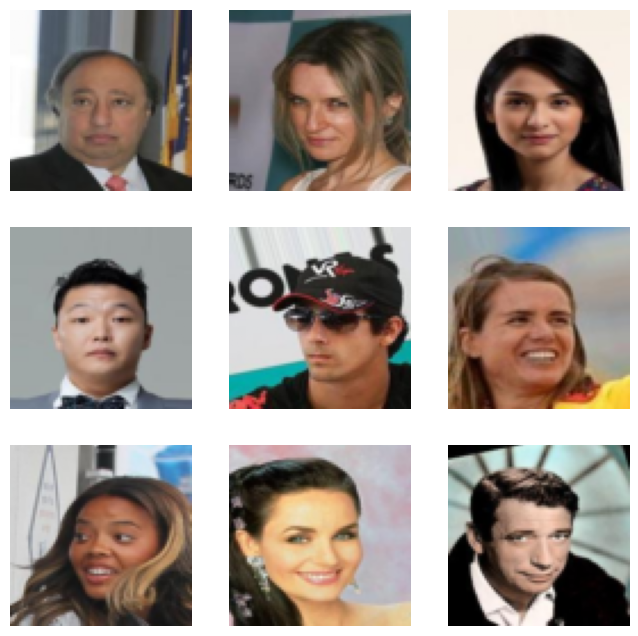

In [309]:
#Function to reverse normalisation (note: we did this during the transform)
def denorm(img):
    return (img * 0.5) + (0.5)      # 0.5 used here as this was the mean in the transform

#Function which will quickly plot a few images from dataset
def show_images(data, cols, rows):
    figure = plt.figure(figsize=(8,8))
    for i in range(1, cols * rows + 1):
        sample_inx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_inx]
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(denorm(img.permute(1,2,0)))          #Need to permute the data to convert from a tensor
        print(label)
    plt.show()

# Show some images from the training set
show_images(train, 3, 3)

## 2. Creating our neural network and training routine

# Scoring Metric 

First we want to define how we are going to measure how well our model is performing ~ usually this is done using accuracy, however given we have a multi-label problem, this is not as applicable for this model.

We want to use the F1 scoring mechanism (inspired by https://learnopencv.com/medical-multi-label/). This basically takes the relationship of a models precision and recall scores to determine a metric for how well the model is doing. Given the imbalanced nature of our dataset (some classes appear more than others), this is not the most ideal metric (works best with balanced dataset), and we will see the consequences of this down the line.

In [310]:
#Calculates the accuracy of the model using the F1 score metric
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold           #Note that the threshold here is when the model determines if something is labelled ~ 0.5 means if it is 50% confident, it will set the label to true.

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F1 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F1.mean(0)

# Defining our NN model and trainer

Now we are going to define our neural network model ~ you can get quite creative here and customize. I tried a range of CNN structures, and found a resnet worked best. 

We are going to use a fairly simple resnet in this case (Note inspiration from https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu), which involves skip connections to allow non-convoluted data to still paly a role in the decision process.

In [311]:
#Defining a single convolutional block in the network
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class MultiLabelCelebClassificationNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = conv_block(DatasetConfig.Channels, 64)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv2 = conv_block(64, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.conv3 = conv_block(256, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.conv4 = conv_block(512, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.Flatten(), 
                                        nn.Linear(1024, 512),
                                        nn.Dropout(0.5),            # These dropout layers help with overfitting
                                        nn.ReLU(),
                                        nn.Linear(512, 256),
                                        nn.Dropout(0.5),
                                        nn.ReLU(),
                                        nn.Linear(256, DatasetConfig.Num_Classes))      #Output should be the number of classes we have and range from 0-1
    
    # Defines one forward pass through the model
    def forward(self ,x):
        out = self.conv1(x)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        return F.sigmoid(out)               #Note the sigmoid here as an output function                      
    
    #In each training step of the model, we want to run the images through the model, return the loss and the score
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        score = F_score(out, targets)  
        loss = F.binary_cross_entropy(out, targets.float())     #Using BCE loss function
        return loss, score
    
    #In each validation step of the model, we want to run the images through the model, return the loss and the score (same as training but with validation dataset)
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           
        loss = F.binary_cross_entropy(out, targets.float()) 
        score = F_score(out, targets)                
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
    
    #Each epoch end calculate the average validation loss and score
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
        
    # At epoch end want to let the user know how the model is going
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_score: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['train_loss'], result['train_score'], result['val_loss'], result['val_score']))

#Create an instance of our model
model = MultiLabelCelebClassificationNetwork().to(device)

Below are some functions which helps load all the data onto the GPUs for quicker training

In [313]:
#Functions to help move images onto GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
# Moving dataloaders onto GPU
train_dl = DeviceDataLoader(trainloader, device)
test_dl = DeviceDataLoader(testloader, device)

In [315]:
#Function which will evaluate out model (wrap in torch no grad to make sure not training)
def evaluate(model, val_loader):
    with torch.no_grad():
        model.eval()            #Sets model to eval mode
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)
    
#Function for training the model
def fit(epochs, lr, model, trainloader, testloader):
    history = []
    optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=lr)     #Using Adam as an optimizer
    
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        train_scores = []
        for batch in tqdm(trainloader, leave=False):
            #Forward Pass
            loss, score = model.training_step(batch)
            train_losses.append(loss)
            train_scores.append(score)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        #Validation Phase
        result = evaluate(model, testloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_score'] = torch.stack(train_scores).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history
    

Finally, with everything set up, we can train our model on the data!

In [316]:
#Training the model
history = fit(TrainingConfig.Num_Epochs, TrainingConfig.Learning_Rate, model, train_dl, test_dl)

  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.2585, train_score: 0.7933, val_loss: 0.1978, val_score: 0.8433


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1983, train_score: 0.8464, val_loss: 0.1755, val_score: 0.8602


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1829, train_score: 0.8584, val_loss: 0.1676, val_score: 0.8707


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1746, train_score: 0.8657, val_loss: 0.1630, val_score: 0.8705


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1675, train_score: 0.8715, val_loss: 0.1632, val_score: 0.8708


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1611, train_score: 0.8772, val_loss: 0.1592, val_score: 0.8783


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1552, train_score: 0.8823, val_loss: 0.1581, val_score: 0.8766


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1493, train_score: 0.8874, val_loss: 0.1594, val_score: 0.8796


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1436, train_score: 0.8929, val_loss: 0.1613, val_score: 0.8747


  0%|          | 0/11396 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1370, train_score: 0.8985, val_loss: 0.1622, val_score: 0.8779


## 3.Evaluating our model and using it to make predictions

Now that our model has finished training, we want to look at its validation/training scores/losses to see how it performed, and also use it to make some predictions on unseen data.

Starting off by plotting the validation and training losses/scores over the number of epochs:

Text(0.5, 1.0, 'Loss vs. No. of epochs')

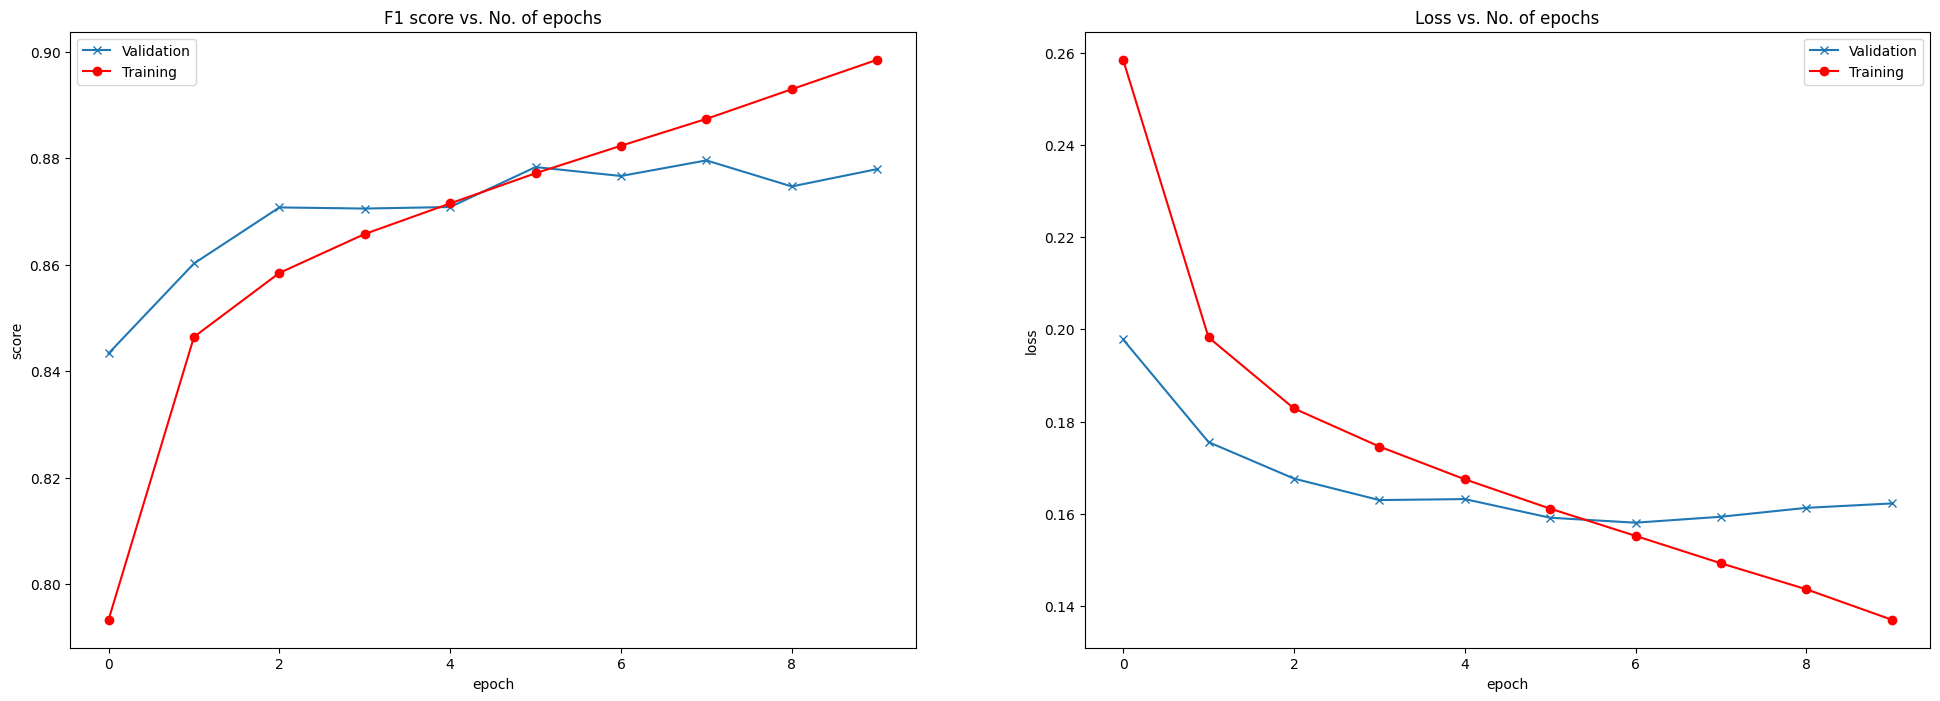

In [317]:
#Plotting the Validation/Training scores
figure = plt.figure(figsize=(24,8))
figure.add_subplot(1, 2, 1)
val_scores = [x['val_score'] for x in history]
plt.plot(val_scores, '-x')
train_scores = [x['train_score'] for x in history]
plt.plot(train_scores, '-ro')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('F1 score vs. No. of epochs')
plt.legend(['Validation', 'Training'])

#Plotting the Validation/Training Losses
figure.add_subplot(1, 2, 2)
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(val_losses, '-x')
plt.plot(train_losses, '-ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Validation', 'Training'])
plt.title('Loss vs. No. of epochs')

IT can be seen that after around 5 epochs the validation loss and accuracy reaches a plateau, while the training loss/score keeps increasing. This indicates over-fitting is occurring ~ I had tried a few different architectures and anti-over-fitting measures (eg. dropout layers, less complex models, data augmentation) for now this was as high as I could get the accuracy.

Now we want to have a closer look at the validation score to see if there is one place/category where we are getting a lower accuracy (here we are going to consider True positives, False positive, True Negative and False Negative).

In [318]:
#Checking the score of each category in the validation dataset
with torch.no_grad():
    model.eval()
    
    TP = torch.zeros(DatasetConfig.Num_Classes).to(device)
    TN = torch.zeros(DatasetConfig.Num_Classes).to(device)
    FP = torch.zeros(DatasetConfig.Num_Classes).to(device)
    FN = torch.zeros(DatasetConfig.Num_Classes).to(device)
    
    #Run through each input
    for images, labels in tqdm(testloader):
        #Load the images onto the GPU
        images = images.to(device)
        labels = labels.to(device)
        
        #Get the predicted labels for each image from the model
        outputs = model(images)
        
        #Run through each of the categories for each image
        for i in range(TrainingConfig.Batch_Size):
            prob = outputs[i] > 0.5
            label = labels[i] > 0.5

            TP = torch.add((prob & label).float(), TP)
            TN = torch.add(((~prob) & (~label)).float(), TN)
            FP = torch.add((prob & (~label)).float(), FP)
            FN = torch.add(((~prob) & label).float(), FN)

    #Print out the total scores and scores for each class
    acc = torch.mean((TP+TN+ 1e-12)/(TP+TN+FN+FP+ 1e-12))
    pre = torch.mean((TP + 1e-12)/(TP+FP+ 1e-12))
    rec = torch.mean((TP+ 1e-12)/(TP+FN+ 1e-12))
    print("Total Network:  Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}".format(acc, pre, rec))
    for i in range(DatasetConfig.Num_Classes):
        acc = torch.mean((TP[i]+TN[i]+ 1e-12)/(TP[i]+TN[i]+FN[i]+FP[i]+ 1e-12))
        pre = torch.mean((TP[i] + 1e-12)/(TP[i]+FP[i]+ 1e-12))
        rec = torch.mean((TP[i]+ 1e-12)/(TP[i]+FN[i]+ 1e-12))
        print("{}:  Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}".format(classes[i+1], acc, pre, rec))

  0%|          | 0/1266 [00:00<?, ?it/s]

Total Network:  Accuracy = 0.9316, Precision = 0.8136, Recall = 0.7300
Attractive:  Accuracy = 0.8175, Precision = 0.8222, Recall = 0.8242
Bags_Under_Eyes:  Accuracy = 0.8438, Precision = 0.6692, Recall = 0.4728
Bald:  Accuracy = 0.9892, Precision = 0.7246, Recall = 0.8176
Black_Hair:  Accuracy = 0.9006, Precision = 0.7966, Recall = 0.7863
Blond_Hair:  Accuracy = 0.9550, Precision = 0.8726, Recall = 0.8057
Brown_Hair:  Accuracy = 0.8699, Precision = 0.7138, Recall = 0.6357
Chubby:  Accuracy = 0.9516, Precision = 0.7012, Recall = 0.2483
Goatee:  Accuracy = 0.9659, Precision = 0.7408, Recall = 0.6911
Gray_Hair:  Accuracy = 0.9805, Precision = 0.7706, Recall = 0.7244
Male:  Accuracy = 0.9812, Precision = 0.9710, Recall = 0.9842
Mustache:  Accuracy = 0.9620, Precision = 0.7393, Recall = 0.2130
No_Beard:  Accuracy = 0.9537, Precision = 0.9606, Recall = 0.9849
Smiling:  Accuracy = 0.9290, Precision = 0.9223, Recall = 0.9313
Wearing_Hat:  Accuracy = 0.9889, Precision = 0.8811, Recall = 0.8944

The results of this are quite interesting ~ we can see that the model has a harder time of determining factors such as bags under eyes, which are likely small details and vary a lot person to person. It also has a lot of trouble determining attractiveness and young, which are loosely defined. To achieve a higher accuracy these categories could be removed from the data, however it is good to leave them in to show what neural networks can and cant determine.

With being young, the recall is higher than the precision (ie. more false positives), indicating the model more skewed towards saying that the person is young. This makes sense as young is harder to define, and however is also the 2nd highest represented trait. This means the model almost always predicts young, and because most of the images are labelled with young, it usually gets it right! 

Note: If you want to test for yourself, put new images in the "test_images" folder.

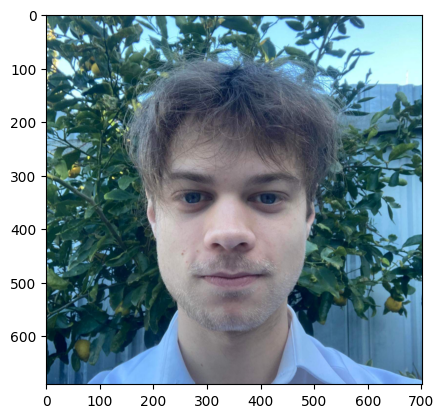

Probability of Attractive:  40.51 %
Probability of Bags_Under_Eyes:  64.23 %
Probability of Bald:  0.00 %
Probability of Black_Hair:  7.29 %
Probability of Blond_Hair:  0.84 %
Probability of Brown_Hair:  31.93 %
Probability of Chubby:  0.14 %
Probability of Goatee:  0.07 %
Probability of Gray_Hair:  0.04 %
Probability of Male:  99.92 %
Probability of Mustache:  0.03 %
Probability of No_Beard:  87.26 %
Probability of Smiling:  3.04 %
Probability of Wearing_Hat:  0.01 %
Probability of Young:  93.87 %


In [319]:
#Testing the model on an unseen image of a person and labelling their traits
def TestSingleImage(file_name, new_image_root_path = '.\\test_images'):  
    new_image = Image.open(os.path.join(new_image_root_path, file_name)).convert('RGB')
    plt.imshow(new_image)
    plt.show()

    #Run the image through the model and see what you get!
    new_image = transform(new_image).unsqueeze(0)
    new_image = new_image.to(device)
    with torch.no_grad():
        model.eval()
        outputs = model(new_image)
        
    #Print the outputs
    for i in range(DatasetConfig.Num_Classes):
        print("Probability of {}:  {:.2f} %".format(classes[i+1], outputs[0,i]*100))
        
TestSingleImage('callan.png')

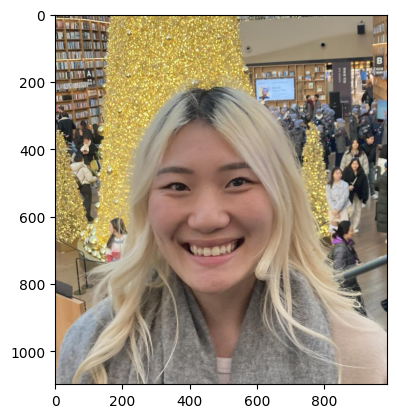

Probability of Attractive:  26.69 %
Probability of Bags_Under_Eyes:  55.29 %
Probability of Bald:  0.05 %
Probability of Black_Hair:  0.10 %
Probability of Blond_Hair:  79.63 %
Probability of Brown_Hair:  2.49 %
Probability of Chubby:  0.51 %
Probability of Goatee:  0.00 %
Probability of Gray_Hair:  1.38 %
Probability of Male:  0.58 %
Probability of Mustache:  0.00 %
Probability of No_Beard:  99.84 %
Probability of Smiling:  99.29 %
Probability of Wearing_Hat:  0.02 %
Probability of Young:  92.23 %


In [330]:
TestSingleImage('jane.jpg')

From the above two data samples, it can be seen that the network can predict attributes such as gender, beards/no-beards, smiling and hair color fairly well. With other factors such as attractiveness and youth, which are hard to define and would have been attributed by the person labelling the dataset, the predictions aren't as strong (if you try this for yourself ~ don't be discouraged if the model doesn't think your attractive! Not only is this very subjective, but the model's accuracy in determining this on the original database was also low).

Interestingly, the model was unable to predict brown hair with a 50%+ accuracy, however it was still higher that all other hair colours. An improvement could be to make the output more readable by selecting the most confident hair color, and stating the opposite cases for certain traits (eg. 0.58% male = 99.42% female).